In [38]:
# CARAR LIBRERIAS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [2]:
# CARGAR BASE DE DATOS

df = pd.read_csv('../BBDD/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# BORRAR COLUMNA ID

df.drop(columns='id', inplace=True)

In [4]:
# COMPROBAR NANS Y PORCENTAJE

print(df.isnull().sum())
print('')
print(df.isnull().sum() / len(df) * 100)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64


In [5]:
# TOTAL DE MISSINGS EN STROKE = 1

print(df[df['stroke'] == 1].count())
print(' ')
print(df[df['stroke'] == 1].isnull().sum())

gender               249
age                  249
hypertension         249
heart_disease        249
ever_married         249
work_type            249
Residence_type       249
avg_glucose_level    249
bmi                  209
smoking_status       249
stroke               249
dtype: int64
 
gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  40
smoking_status        0
stroke                0
dtype: int64


In [6]:
# SUSTITUIR EN COLUMNA 'GENDER' FEMALE POR 0 Y MALE POR 1

df.loc[df['gender'] == 'Female', 'gender'] = 0
df.loc[df['gender'] == 'Male', 'gender'] = 1

# SUSTITUIR EN COLUMNA 'EVER_MARRIED' NO POR 0 Y YES POR 1

df.loc[df['ever_married'] == 'No', 'ever_married'] = 0
df.loc[df['ever_married'] == 'Yes', 'ever_married'] = 1

# SUSTITUIR EN COLUMNA 'RESIDENCE TYPE' RURAL POR 0 Y URBAN POR 1

df.loc[df['Residence_type'] == 'Rural', 'Residence_type'] = 0
df.loc[df['Residence_type'] == 'Urban', 'Residence_type'] = 1

In [7]:
# BORRAR FILA CON GENDER 'OTHER'

df.drop(index= 3116, inplace=True)

# RESETEAR LOS VALORES DEL INDICE

df.reset_index(drop = True, inplace = True)

In [8]:
# SEPARAR EN DISTINTAS COLUMNAS LAS DIFERENTES CATEGORIAS DE 'WORK TYPE' Y 'SMOKING STATUS'

df = pd.get_dummies(data=df, columns=['work_type', 'smoking_status'])

In [9]:
# CAMBIAR TIPOS EN COLUMNAS

df = df.astype({
    'gender': 'int64',
    'age': 'int64',
    'ever_married': 'int64',
    'Residence_type':'int64'
})

In [10]:
# RENOMBRAR COLUMNA RESIDENCE_TYPE

df.rename(columns={'Residence_type': 'residence_type'}, inplace=True)

In [11]:
# REORDENAR COLUMNAS

df = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'stroke']]

# DIVIDIR EN TRAIN Y TEST

In [12]:
# DIVIDIR EN TRAIN Y TEST

X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# IMPUTAR MISSINGS MEDIANTE KNN

imputer = KNNImputer(n_neighbors=5)

imputer.fit(X_train[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

X_train[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']] = imputer.transform(X_train[['gender', 'age', 'hypertension',                'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

In [14]:
# COMPROBAR QUE NO HAY MISSINGS

X_train.isnull().sum()

gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
residence_type                    0
avg_glucose_level                 0
bmi                               0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [15]:
# BALANCEAR TARGET CON SMOTE

from collections import Counter

counter = Counter(y_train)
print('Antes de SMOTE', counter)

smt = SMOTE(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_smt)
print('Despues de SMOTE', counter)

Antes de SMOTE Counter({0: 3900, 1: 187})
Despues de SMOTE Counter({0: 3900, 1: 3900})


# TEST

In [16]:
# IMPUTAR MISSINGS MEDIANTE KNN

X_test[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']] = imputer.transform(X_test[['gender', 'age', 'hypertension',                'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 
       'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
       'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes']])

# MODELOS

### LOGISTIC REGRESSION

#### MODELO

In [141]:
# LOGISTIC REGRESSION

log_reg = LogisticRegression(random_state=42)

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 0.5, 1, 5, 10],
    'max_iter': [50, 100, 500],
    'solver': ['sag']
}

clf = GridSearchCV(estimator= log_reg, param_grid= parameters, n_jobs=-1, cv=10, verbose=2, scoring='recall')

clf.fit(X_train_smt, y_train_smt)

print(clf.best_params_)
print()
print('Best score:', clf.best_score_)

log_model = clf.best_estimator_

log_model.score(X_test, y_test)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
{'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'sag'}

Best score: 0.8146153846153845


0.7407045009784736

#### MATRIZ DE CONFUSION

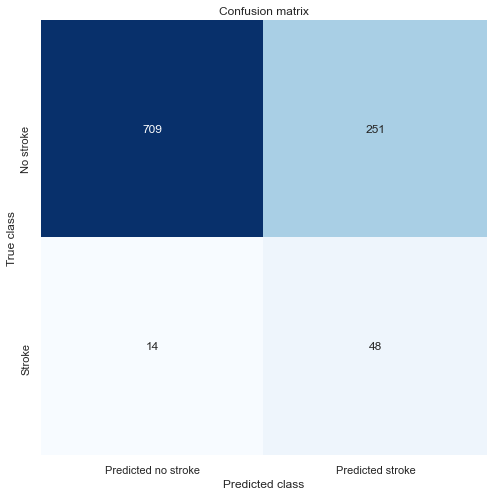

              precision    recall  f1-score   support

           0       0.98      0.74      0.84       960
           1       0.16      0.77      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.76      0.55      1022
weighted avg       0.93      0.74      0.81      1022



In [142]:
def mostrar_resultados(y_test, predictions):
    
    c_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 8))
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke']);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, predictions))
 
predictions = log_model.predict(X_test)

mostrar_resultados(y_test, predictions)

#### ROC AUC CURVE

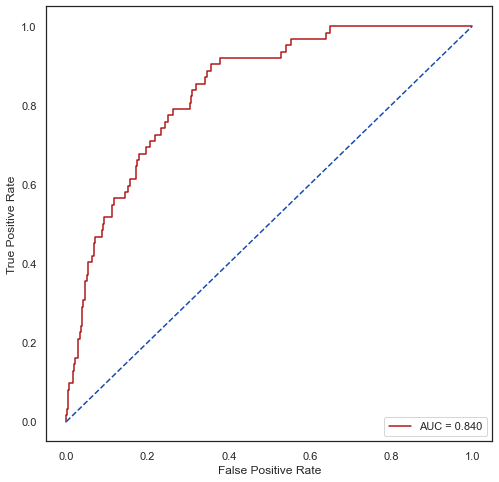

In [143]:
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:,1]

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### RANDOM FOREST

#### MODELO

In [108]:
# RANDOM FOREST

rf = RandomForestClassifier(random_state=42)

parameters = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2,3],
    'max_features': [1, 2, 3]
}

clf = GridSearchCV(estimator= rf, param_grid= parameters, n_jobs=-1, cv=10, verbose=2, scoring='recall')

clf.fit(X_train_smt, y_train_smt)

print(clf.best_params_)
print()
print('Best score:', clf.best_score_)

rf_model = clf.best_estimator_

rf_model.score(X_test, y_test)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
{'max_depth': 3, 'max_features': 3, 'n_estimators': 300}

Best score: 0.9038461538461539


0.7749510763209393

#### MATRIZ DE CONFUSION

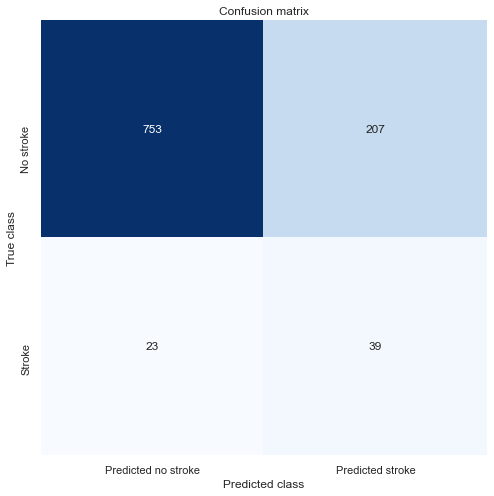

              precision    recall  f1-score   support

           0       0.97      0.78      0.87       960
           1       0.16      0.63      0.25        62

    accuracy                           0.77      1022
   macro avg       0.56      0.71      0.56      1022
weighted avg       0.92      0.77      0.83      1022



In [109]:
def mostrar_resultados(y_test, predictions):
    
    c_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 8))
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke']);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, predictions))
 
predictions = rf_model.predict(X_test)

mostrar_resultados(y_test, predictions)

#### ROC AUC CURVE

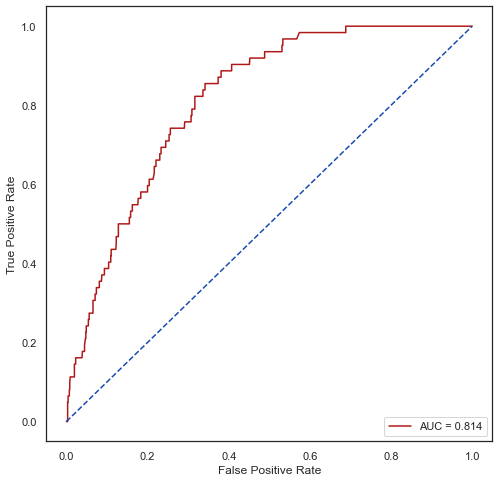

In [102]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:,1]

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### FEATURE IMPORTANCE

In [103]:
# FEATURE IMPORTANCE

f_imp3 = pd.DataFrame(columns = ['feature', 'importance'], index = range(1,18))
for i in range(len(f_imp3.index)):
    f_imp3.iloc[i, 0] = X_train_smt.columns.to_list()[i]
f_imp3['importance'] = rf_model.feature_importances_
f_imp3 = f_imp3.sort_values('importance', ascending = False)
f_imp3[0:17].style.background_gradient(cmap = 'Blues')

,feature,importance
2,age,0.151997
3,hypertension,0.085720
4,heart_disease,0.072931
14,smoking_status_Unknown,0.072093
15,smoking_status_formerly smoked,0.070319
6,residence_type,0.066890
16,smoking_status_never smoked,0.062385
5,ever_married,0.060847
12,work_type_Self-employed,0.058576
7,avg_glucose_level,0.051623


### XGBOOST

#### MODELO

In [17]:
# XGBOOST 1

xgb = XGBClassifier()

parameters = {
    'n_estimators': [90, 91, 92, 93, 94, 95],
    'booster': ['gbtree'],
    'max_depth': [2],
    'learning_rate': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}

clf = GridSearchCV(estimator= xgb, param_grid= parameters, n_jobs=-1, cv=10, verbose=2, scoring='recall')

clf.fit(X_train_smt, y_train_smt)

print(clf.best_params_)
print()
print('Best score:', clf.best_score_)

xgb_model = clf.best_estimator_

xgb_model.score(X_test, y_test)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[12:22:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 94}

Best score: 0.9891443129520054


0.9383561643835616

In [104]:
# XGBOOST 2

xgb = XGBClassifier()

parameters = {
    'n_estimators': [150],
    'booster': ['gbtree'],
    'max_depth': [3, 4],
    'learning_rate': [0.05]
}

clf = GridSearchCV(estimator= xgb, param_grid= parameters, n_jobs=-1, cv=10, verbose=2, scoring='recall')

clf.fit(X_train_smt, y_train_smt)

print(clf.best_params_)
print()
print('Best score:', clf.best_score_)

xgb_model = clf.best_estimator_

xgb_model.score(X_test, y_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[16:05:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150}

Best score: 0.9423076923076923


0.9383561643835616

#### MATRIZ DE CONFUSION

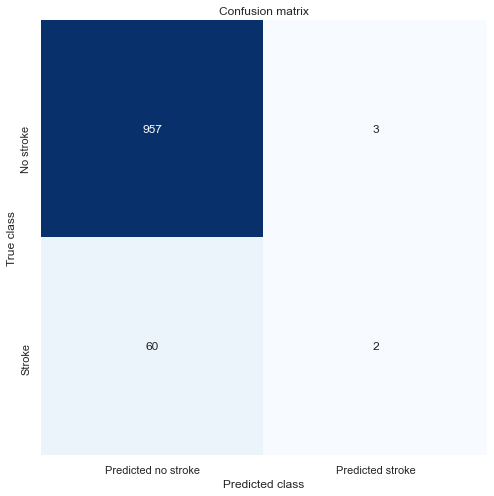

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.40      0.03      0.06        62

    accuracy                           0.94      1022
   macro avg       0.67      0.51      0.51      1022
weighted avg       0.91      0.94      0.91      1022



In [105]:
def mostrar_resultados(y_test, predictions):
    
    c_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 8))
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke']);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, predictions))
 
predictions = xgb_model.predict(X_test)

mostrar_resultados(y_test, predictions)

#### ROC AUC CURVE

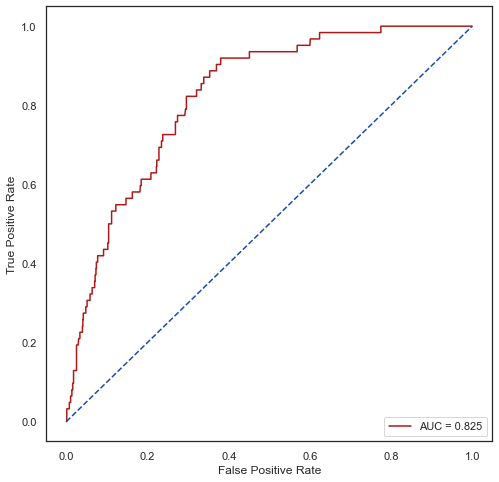

In [106]:
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:,1]

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### FEATURE IMPORTANCE

In [107]:
# FEATURE IMPORTANCE

f_imp3 = pd.DataFrame(columns = ['feature', 'importance'], index = range(1,18))
for i in range(len(f_imp3.index)):
    f_imp3.iloc[i, 0] = X_train_smt.columns.to_list()[i]
f_imp3['importance'] = xgb_model.feature_importances_
f_imp3 = f_imp3.sort_values('importance', ascending = False)
f_imp3[0:17].style.background_gradient(cmap = 'Blues')

,feature,importance
2,age,0.142345
11,work_type_Private,0.097826
14,smoking_status_Unknown,0.093071
6,residence_type,0.088168
1,gender,0.082207
16,smoking_status_never smoked,0.082027
9,work_type_Govt_job,0.077218
15,smoking_status_formerly smoked,0.069733
4,heart_disease,0.062257
5,ever_married,0.055391
